In [1]:
from fore_utils import WeatherData, train_model, evaluate_model

In [2]:
window_size = 24
steps = 24
spaces = 0
hidden_size = 32
batch_size = 64
series_target = False
verbose = True

# If on lightining AI
lightning = True

train_set = WeatherData(window_size=window_size, 
                        step_size=steps, 
                        set='train', 
                        spaces=spaces, 
                        lightning=lightning, 
                        series_target=series_target,
                        verbose=verbose)
    
val_set = WeatherData(window_size=window_size,
                         step_size=steps, 
                         set='val', 
                         spaces=spaces, 
                         lightning=lightning, 
                         series_target=series_target, 
                         verbose=verbose)

dataset_config = {
    "window_size" : [train_set.window_size],
    "step_size" : [train_set.step_size],
    "spaces" : [train_set.spaces],
    "batch_size": [batch_size],
    "series_target": [train_set.series_target]
}


Details for train set:
Data from ['2018', '2019', '2020', '2021'] loaded
Details for val set:
Data from ['2022'] loaded


Features shape: torch.Size([35064, 6])
Targets shape: torch.Size([35064])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023
Features shape: torch.Size([8760, 6])
Targets shape: torch.Size([8760])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023


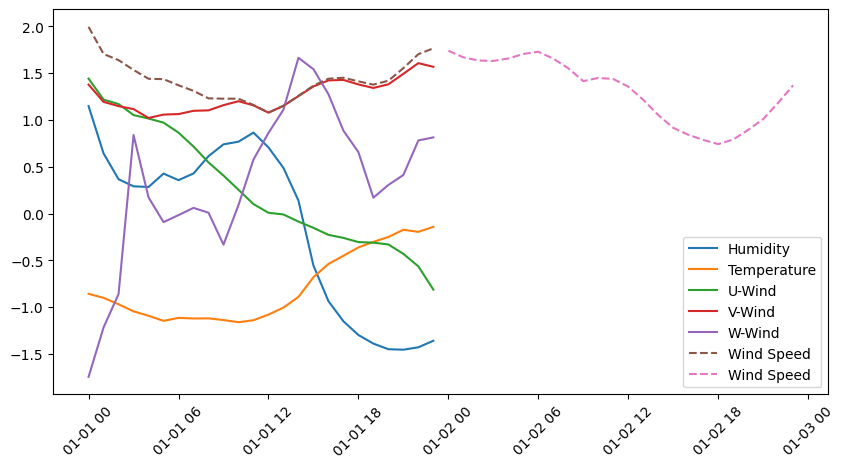

In [3]:
train_set.re_init()
val_set.re_init()
train_set.plot_point()

In [67]:
import torch
import torch.nn as nn

import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        return x + self.encoding[:x.size(0), :].to(x.device)


class TransformerModel_Point(nn.Module):
    def __init__(self, name = 'Transformer', input_size: int = 24, variables: int = 6, hidden_size=64, nhead=8, num_layers=4, output_size: int = 12):
        super(TransformerModel_Point, self).__init__()

        self.name = name

        d_model = hidden_size   

        input_dim = input_size * variables
        self.encoder = nn.Linear(input_dim, d_model)
        
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Encoder Layers with Dropout and Normalization
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        self.dropout = nn.Dropout(0.1)
        self.norm = nn.LayerNorm(d_model)
        self.decoder = nn.Linear(d_model, output_size)
        
        # Weight Initialization
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.encoder(x)
        # print(x.shape)
        x = self.pos_encoder(x)
        # print(x.shape)
        
        # x = x.unsqueeze(1)
        x = self.dropout(self.norm(x))
        # print(x.shape)
        
        x = self.transformer_encoder(x)

        x = self.decoder(x[:, -1, :])
        
        return x


class MLP_Point(nn.Module):
    def __init__(self, name = 'MLP', input_size: int = 24, hidden_size: int = 64, output_size: int = 12, variables: int = 6):
        super(MLP_Point, self).__init__()

        self.name = name
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        input_size = input_size * variables
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


class Dense_Point(nn.Module):
    def __init__(self, name = 'Dense', input_size: int = 24, hidden_size: int = 64, output_size: int = 12, variables: int = 6, dropout_prob: float = 0.5):
        super(Dense_Point, self).__init__()
        self.name = name
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        input_size = input_size * variables
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.LayerNorm(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.LayerNorm(hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        return x


class LSTM_Point(nn.Module):
    def __init__(self, name='LSTM', input_size: int = 24, hidden_size: int = 64, output_size: int = 12, variables: int = 6):
        super(LSTM_Point, self).__init__()
        self.name = name
        # self.input_size = input_size * variables
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.variables = variables
        
        # Initialize LSTM and fully connected layer
        self.lstm = nn.LSTM(variables, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Reshape x to match the LSTM input dimensions
        batch_size = x.size(0) # 64
        sequence_length = x.size(1) # 48

        x = x.reshape(batch_size, sequence_length, self.variables) # [64, 48, 6]

        # print(x.shape)

        # Pass through LSTM and fully connected layer
        x, _ = self.lstm(x) # Error RuntimeError: shape '[768, 1]' is invalid for input of size 6144

        # print(x.shape)
        x = self.fc(x[:, -1, :])
        return x

    

class EnsembleModel(nn.Module):
    def __init__(self, transformer_params, mlp_params, dense_params, lstm_params, output_size=24, name = 'Ensemble'):
        super(EnsembleModel, self).__init__()

        self.name = name
        # Initialize individual models
        self.transformer = TransformerModel_Point(**transformer_params)
        self.mlp = MLP_Point(**mlp_params)
        self.dense = Dense_Point(**dense_params)
        self.lstm = LSTM_Point(**lstm_params)

        # Linear layer to combine model outputs
        self.combiner = nn.Linear(output_size * 4, output_size)

    def forward(self, x):
        # Get predictions from each model
        transformer_out = self.transformer(x)
        mlp_out = self.mlp(x)
        dense_out = self.dense(x)
        lstm_out = self.lstm(x)

        # Concatenate all model outputs along the last dimension
        combined_output = torch.cat((transformer_out, mlp_out, dense_out, lstm_out), dim=1)

        # Pass through the combiner layer to get the final output
        final_output = self.combiner(combined_output)
        return final_output

In [68]:
from torch.utils.data import DataLoader

# User settings
window_size = 48
steps = 24
spaces = 0
batch_size = 64
series_target = False
all_variables = False
verbose = False

# Class updates
train_set.window_size = window_size
train_set.step_size = steps
train_set.spaces = spaces
train_set.all_variables = all_variables
train_set.series_target = series_target
train_set.verbose = verbose

train_set.re_init()

val_set.window_size = window_size
val_set.step_size = steps
val_set.spaces = spaces
val_set.all_variables = all_variables
val_set.series_target = series_target
val_set.verbose = verbose

val_set.re_init()


Ensemble


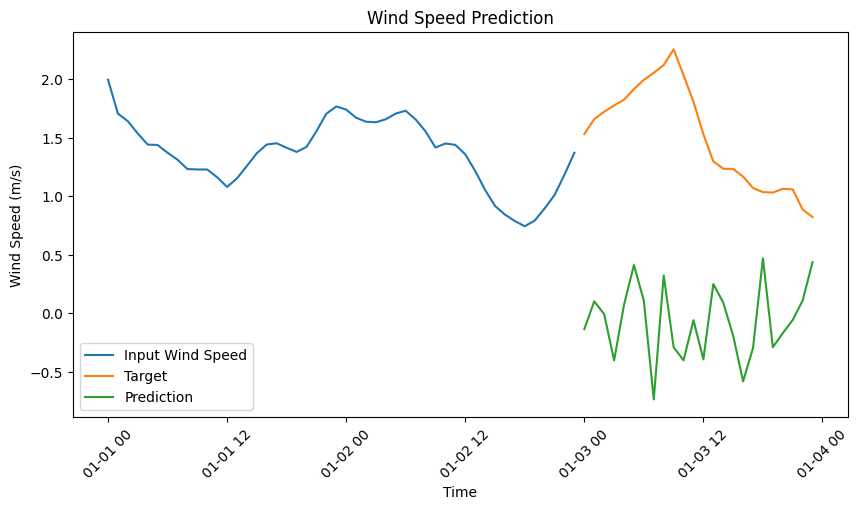

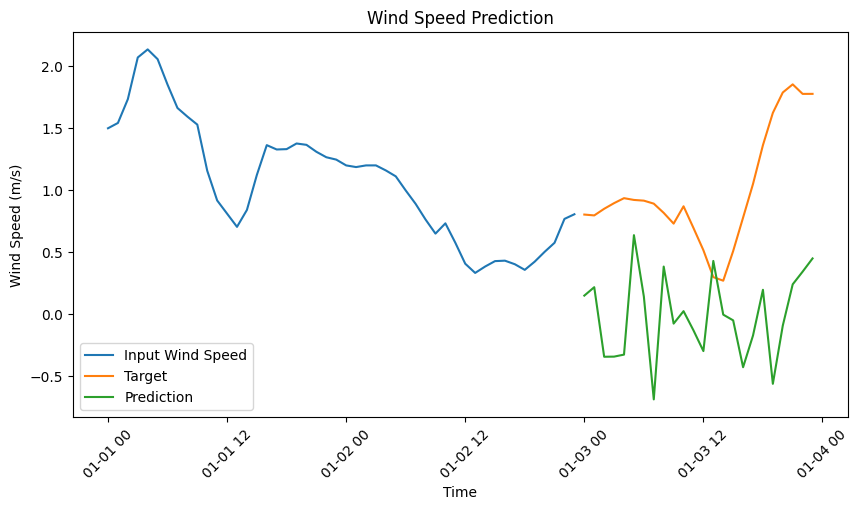

In [72]:
transformer_params = {
    'name' : 'Transformer',
    'input_size': window_size,  # 48 time steps
    'variables': 6,
    'hidden_size': hidden_size, 
    'nhead': 8, 
    'num_layers': 4, 
    'output_size': steps  # Predicting 24 future steps
}

mlp_params = {
    'name' : 'MLP',
    'input_size': window_size,  # 48 time steps
    'hidden_size': hidden_size, 
    'output_size': steps,  # Predicting 24 future steps
    'variables': 6
}

dense_params = {
    'name' : 'Dense',
    'input_size': window_size,  # 48 time steps
    'hidden_size': hidden_size, 
    'output_size': steps,  # Predicting 24 future steps
    'variables': 6, 
    'dropout_prob': 0.5
}

lstm_params = {
    'name' : 'LSTM',
    'input_size': window_size,  # 48 time steps
    'hidden_size': hidden_size, 
    'output_size': steps,  # Predicting 24 future steps
    'variables': 6
}


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Options: MLP_Point, Dense_Point, LSTM_Point, TransformerModel_Point
# model_point = MLP_Point(**mlp_params)
# model_point = Dense_Point(**dense_params)
# model_point = LSTM_Point(**lstm_params)
# model_point = TransformerModel_Point(**transformer_params)
model_point = EnsembleModel(transformer_params, mlp_params, dense_params, lstm_params, output_size=steps)

seed = 0

print(model_point.name)
train_set.plot_point_pred(model=model_point, seed = seed)
val_set.plot_point_pred(model=model_point, seed = seed)



In [73]:
for x, b, y in train_loader:
    print(x.shape)
    print(b.shape)
    print(y.shape)
    break

pred = model_point(x)

print('Pred: ', pred.shape)

torch.Size([64, 48, 6])
torch.Size([64, 48])
torch.Size([64, 24])
Pred:  torch.Size([64, 24])


In [74]:
import wandb

n_epochs = 10
warmup_epochs = 10
initial_lr = 1e-4
early_stopping_patience = 5
checkpoint_path = f'best_{model_point.name}_{window_size}_{hidden_size}_{steps}.pth'

config = {
    "window_size": [window_size],
    "hidden_size": [hidden_size],
    "steps": [steps],
    "batch_size": [batch_size],
    "n_epochs": n_epochs,
    "warmup_epochs": warmup_epochs,
    "initial_lr": initial_lr,
    "early_stopping_patience": early_stopping_patience,
    "checkpoint_path": checkpoint_path
}

wandb.init(project="point-point-forecasts", name=f'model_{model_point.name}_{window_size}_{hidden_size}_{steps}', config=config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_point.to(device)

print(device)
                         
train_model(model_point, train_loader, val_loader, n_epochs=n_epochs, warmup_epochs=warmup_epochs,
            initial_lr=initial_lr, early_stopping_patience=early_stopping_patience, checkpoint_path=checkpoint_path, device=device,
            debug = False, criterion=nn.L1Loss())


epoch,▁▃▆█
learning_rate,▁▃▆█
train_loss,█▇▃▁
val_loss,█▇▂▁
epoch,3
learning_rate,5e-05
train_loss,0.50202
val_loss,0.49081


cuda
Epoch 0, Batch 0, Loss: 1.3254
Epoch 0, Batch 100, Loss: 1.0997
Epoch 0, Batch 200, Loss: 0.8270
Epoch 0, Batch 300, Loss: 0.8119
Epoch 0, Batch 400, Loss: 0.7416


KeyboardInterrupt: 

In [ ]:
test_loader = DataLoader(WeatherData(window_size=window_size, step_size=steps, set='test', spaces=spaces,intervals=intervals, lightning=True, verbose=True),
                            batch_size=batch_size, shuffle=False)

model_point.load_state_dict(torch.load(checkpoint_path))
model_point.eval()

test_loss = evaluate_model(model_point, test_loader, device)

print(f"Test loss: {test_loss}")

wandb.log({"test_loss": test_loss})

wandb.finish()